In [1]:
import sys
print (sys.version)

3.5.1 |Anaconda 4.0.0 (64-bit)| (default, Feb 16 2016, 09:49:46) [MSC v.1900 64 bit (AMD64)]


In [2]:
import ctypes
print(ctypes.sizeof(ctypes.c_voidp))

8


In [1]:
#like with BLPAPI, download the TIA package from GitHub and paste in the directory_
#C:\Users\cp85vc\AppData\Local\Continuum\Anaconda3\Lib\site-packages\tia
#There was a NameError when calling 'resp', 'basestring' not defined
#from C:\Users\cp85vc\AppData\Local\Continuum\Anaconda3\lib\site-packages\tia\bbg\v3api.py 
#so had to change all them to 'str', close-re-open and then it worked :)
#examples :  http://nbviewer.jupyter.org/github/bpsmith/tia/blob/master/examples/v3api.ipynb
import blpapi
import numpy as np
import pandas as pd
#import matplotlib as plt -->error "no show module?"
import matplotlib.pyplot as plt
%matplotlib inline  
import tai  #basic tech analysis module
#this is more advanced module  but need to install whole talib._ta_lib  -->import talib
import datetime
import datetime as dt#  --->NameError: name 'datetime' is not defined
from datetime import date
import tia.bbg.datamgr as dm
from tia.bbg import LocalTerminal

# BDH
''''waste of space BBG example

session = blpapi.Session()
if not session.start():
    print("Failed to start session.")
if not session.openService("//blp/refdata"):
    print("Failed to open service.")

service = session.getService("//blp/refdata")
request = service.createRequest("HistoricalDataRequest")

request.append("securities", "EUR Curncy")
#request.append("fields", "TRAIL_12M_EPS")
request.append("fields", "PX_LAST")

request.set("startDate", "20151230")
request.set("endDate","20170101")

session.sendRequest(request)
endReached = False

while endReached == False:
    ev = session.nextEvent()
    if ev.eventType() == blpapi.Event.RESPONSE or ev.eventType() == blpapi.Event.PARTIAL_RESPONSE:
        for msg in ev:
           print(msg)

    if ev.eventType() == blpapi.Event.RESPONSE:
        endReached = True'''

In [3]:
class DownloadData(object):
    #can pass single 'PX_LAST', or list ['PX_LAST', 'PX_HIGH']
    def __init__(self, pair, fields, startDate, endDate, period, source):
        
        self.pair = pair #'EURUSD'
        self.fields = fields  #dt.datetime(2000, 12, 1)
        self.startDate = startDate #dt.datetime.today() 
        self.endDate = endDate #datetime.date(2018, 1,14)
        print(endDate)
        self.period = period #'DAILY', 'MONTHLY', 'YEARLY'
        self.source = source #blp or quandl
        
    def get_data_blp_historical(self):
        '''imports historical data from bbg api, converts to dataframe '''
        formattedPair = self.pair +str(' Curncy')
        resp = LocalTerminal.get_historical(formattedPair, self.fields, self.startDate, self.endDate,  self.period)
        df = resp.as_frame()
        #use below to start at second row , to get rid of the extra column index ['XYZ Curncy'] title on top
        #else df MultiIndex(levels=[['EURUSD Curncy'], ['PX_OPEN', 'PX_LAST', 'PX_LOW', 'PX_HIGH']]
        df.columns = df.columns.get_level_values(1) 
        
        return df
    
    def get_data_blp_intraday(self, daylag, minutes):
        '''imports intraday data from bbg api, converts to dataframe '''
        formattedPair = self.pair +str(' Curncy')

        event = 'TRADE'
        #starting point, if BDay(-10), starts 10days ago for instance
        #dt = pd.datetools.BDay(-dayLag).apply(pd.datetime.now())
        delta = pd.datetools.BDay(-daylag).apply(self.endDate)
     
        start = pd.datetime.combine(delta, datetime.time(0, 0))   #time(hour, minute)
        
        #endDay = datetime.date(2017,12,3)
        #end = pd.datetime.combine(endDay, datetime.time(23, 30))
        end = self.endDate
        print(end)

        intraDayDf = LocalTerminal.get_intraday_bar(formattedPair, event, start, end, interval= minutes).as_frame()

        #f.set_index('time')  wrong
        intraDayDf = intraDayDf.set_index('time')
        return intraDayDf
    
    def blp_data_get_returns(self):
        
        df = self.get_data_blp_historical()
        df['return']= (df['PX_LAST']/(df['PX_LAST'].shift(1)) -1.0)*100
        return df
    
    def blp_data_MAs(self):
        
        #first instantiate the object, then can play with it
        df = self.get_data_blp_historical()
  
        #df['ATR']= [(df['PX_HIGH']-df['PX_LOW']) in df.columns if 'PX_HIGH' in 
            
        #df['prevCloseToLow'] = (df['PX_LAST'].shift(1) -['PX_LOW']) #if prices gap higher and today's low > yest close_
        #df['HighToPrevClose'] = (max(df['PX_HIGH']-df['PX_LAST'].shift(1),0.0))
    
        df['ma21'] = df['PX_LAST'].rolling(21).mean()
        df['ma55'] = df['PX_LAST'].rolling(55).mean()
        df['ma100'] = df['PX_LAST'].rolling(100).mean()
        df['ma200'] = df['PX_LAST'].rolling(200).mean()
        return df
        
    '''def futureMoves(self, days):
        #get data
        df = self.getDataBBG()        
        df['xMin'] = df['PX_LAST'].rolling(days).min()
        return df
    
        
    def calculateExtremes(self, days):
        #get data
        df = self.get_data()
        
        #calculate lowest price in past n-days
        df['running_low'] = df['PX_LOW'].shift(1).rolling(days).min()
        #calculate latest price distance from low 
        df['distance_from_low'] = (df['PX_LAST'] - df['running_low']) / df['PX_LAST']  #see if can use  df[''].diff()
        #create a signal if last price is lower than running_low
        df['breaking_lower'] = np.where(df['PX_LAST'] < df['running_low'], 1.0, 0.0)
        
        #calculate max price in past n-days
        df['running_high'] =df['PX_HIGH'].shift(1).rolling(days).max()
        df['distance_from_high'] = (df['running_high'] - df['PX_LAST'] )/df['PX_LAST']
        df['breaking_higher'] = np.where(df['PX_LAST'] > df['running_high'], 1.0, 0.0)
        
        return df

        
    def get_data_quandL(self):
        return 0  '''

##Download Houlry Data from 200 days ago##

In [51]:
hourly = DownloadData(pair = 'EURUSD', 
                      fields = 'PX_LAST',# 'PX_LOW', 'PX_HIGH'], #, 'EVENTS'], 
                      startDate = start, 
                      endDate = dt.datetime.today(), #datetime.date(2017,1,14), 
                      period = 'DAILY', 
                      source = 'blp')

hourly = hourly.get_data_blp_intraday(200, 60)
hourly.to_csv('yuguang.csv')
hourly.head()

2018-03-08 17:47:58.807478
2018-03-08 17:47:58.807478


,close,high,low,numEvents,open,value,volume
time,,,,,,,
2017-08-23 21:00:00,1.1809,1.1814,1.1806,17123,1.1807,0.0,0
2017-08-23 22:00:00,1.1811,1.1821,1.1808,11905,1.1809,0.0,0
2017-08-23 23:00:00,1.1816,1.1820,1.1811,13519,1.1811,0.0,0
2017-08-24 00:00:00,1.1809,1.1820,1.1808,19446,1.1816,0.0,0
2017-08-24 01:00:00,1.1801,1.1811,1.1801,21240,1.1809,0.0,0


##Download yearly data for a few securities, test a simple hypothesis

In [4]:
#instantiate objects
start = dt.datetime(1998, 12, 1)  #year, month, day

end = dt.datetime.today()
#stocks = resp2 = LocalTerminal.get_historical(['GM US EQUITY','NLY US EQUITY'], ['PX_OPEN', 'PX_LAST', 'PX_HIGH'], 
            #                             start='1/1/1992', end='3/1/2017', period='YEARLY')
#eur = DownloadData(pair = 'EURUSD',fields = ['PX_OPEN', 'PX_LAST','PX_LOW', 'PX_HIGH'],startDate = start,\
 #                  endDate = end, period =  'YEARLY')
eur = DownloadData(pair = 'EURUSD',fields = ['PX_LAST'],startDate = start,\
                   endDate = end, period =  'YEARLY', source = 'blp')

ussw5 = DownloadData(pair = 'USSW5',fields = ['PX_LAST'],startDate = start,\
                   endDate = end, period =  'YEARLY', source = 'blp')

eusa5 = DownloadData(pair = 'EUSA5',fields = ['PX_LAST'],startDate = start,\
                   endDate = end, period =  'YEARLY', source = 'blp')
                     
spx = DownloadData(pair = 'SPX',fields = ['PX_LAST'],startDate = start,\
                   endDate = end, period =  'YEARLY', source = 'blp')
                   

In [4]:
#download data
eur = eur.get_data_blp_historical()
ussw5 = ussw5.get_data_blp_historical()
eusa5 = eusa5.get_data_blp_historical()
spx = spx.get_data_blp_historical()

In [7]:
#merge dfs
merged = (pd.concat([eur, ussw5, eusa5, spx], join = 'inner' , axis = 1))
merged.columns = ['eur', 'us5', 'eu5', 'spx']
merged['eur_ret'] = (merged['eur']/merged['eur'].shift(1) - 1)*100
merged['spx_ret'] = merged['spx']/merged['spx'].shift(1) - 1
merged['diff']  = -merged['us5']  + merged['eu5']
merged['diff_ret'] = merged['diff']- merged['diff'].shift(1)
merged['hypot'] = (merged['diff_ret'] < 0) & (merged['eur_ret'] < 0)
merged.tail(10)

,eur,us5,eu5,spx,eur_ret,spx_ret,diff,diff_ret,hypot
date,,,,,,,,,
2008-12-31,1.3973,2.1330,3.250,903.25,-4.228924,-0.384858,1.1170,0.7400,False
2009-12-31,1.4326,2.9810,2.810,1115.10,2.526301,0.234542,-0.1710,-1.2880,False
2010-12-31,1.3387,2.1740,2.491,1257.64,-6.554516,0.127827,0.3170,0.4880,False
2011-12-30,1.2959,1.2245,1.724,1257.60,-3.197132,-0.000032,0.4995,0.1825,False
2012-12-31,1.3192,0.8645,0.766,1426.19,1.797978,0.134057,-0.0985,-0.5980,False
2013-12-31,1.3743,1.7860,1.261,1848.36,4.176774,0.296012,-0.5250,-0.4265,False
2014-12-31,1.2098,1.7715,0.360,2058.90,-11.969730,0.113906,-1.4115,-0.8865,True
2015-12-31,1.0856,1.7369,0.331,2043.94,-10.266160,-0.007266,-1.4059,0.0056,False
2016-12-30,1.0520,1.9752,0.075,2238.83,-3.095063,0.095350,-1.9002,-0.4943,True


In [105]:
eur2 = DownloadData(pair = 'EURUSD',fields = ['PX_LAST'],startDate = start,\
                   endDate = end, period =  'MONTHLY', source = 'blp')

eur2 = eur2.blp_data_get_returns()
threshhold = 2.2
idxmask = eur2.index[eur2['return']>threshhold]
print(idxmask)
print(len(idxmask))
days_around_date = 1

temp_index = [eur2.loc[timestamp - pd.Timedelta(days_around_date, unit= 'M') :
                     timestamp + pd.Timedelta(days_around_date, unit ='M')].index for timestamp in idxmask]
idx = np.unique(np.concatenate(temp_index))
df1 = eur2.loc[idx]

#df1['return'] = ((df1['PX_LAST']/df1['PX_LAST'].shift(1))-1.0)*100.0
df1.tail(10)

DatetimeIndex(['1999-07-30', '2000-05-31', '2000-11-30', '2000-12-29',
               '2001-07-31', '2001-08-31', '2002-04-30', '2002-05-31',
               '2002-06-28', '2002-12-31', '2003-01-31', '2003-04-30',
               '2003-05-30', '2003-09-30', '2003-11-28', '2003-12-31',
               '2004-10-29', '2004-11-30', '2006-01-31', '2006-04-28',
               '2006-11-30', '2007-04-30', '2007-09-28', '2008-03-31',
               '2008-12-31', '2009-03-31', '2009-05-29', '2010-07-30',
               '2010-09-30', '2010-10-29', '2010-12-31', '2011-01-31',
               '2011-03-31', '2011-04-29', '2011-10-31', '2012-06-29',
               '2012-08-31', '2012-09-28', '2013-01-31', '2013-04-30',
               '2013-07-31', '2013-09-30', '2014-02-28', '2015-04-30',
               '2015-12-31', '2016-03-31', '2017-01-31', '2017-04-28',
               '2017-05-31', '2017-07-31', '2017-11-30', '2018-01-31'],
              dtype='datetime64[ns]', name='date', freq=None)
52


,PX_LAST,return
date,,
2017-03-31,1.0653,0.728064
2017-04-28,1.0897,2.290435
2017-05-31,1.1244,3.184363
2017-06-30,1.1426,1.618641
2017-07-31,1.1842,3.640819
2017-10-31,1.1646,-1.422042
2017-11-30,1.1904,2.215353
2017-12-29,1.2005,0.848454
2018-01-31,1.2414,3.406914


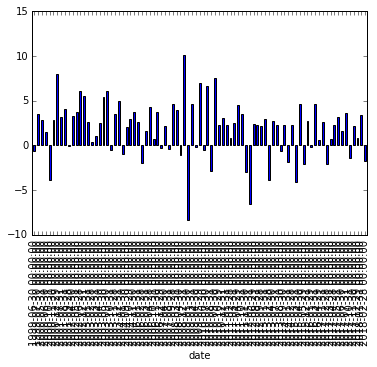

In [106]:
df1['return'].plot(kind = 'bar')
plt.show()
'''dfNew['return'].dropna().plot(kind = 'hist', bins = 50, range = (-5, 5))
plt.xlabel('returns')
plt.show()'''

In [109]:
'''#with increments of 0.1, check how many days returns are greater than 1% to 2%
check_range = np.arange(1.0, 2.1, 0.1)
for i in check_range:
    counter = len(dfNew.index[dfNew['return']>i])
    print('days greater than '+str(i)+' are ' + str(counter))'''

"#with increments of 0.1, check how many days returns are greater than 1% to 2%\ncheck_range = np.arange(1.0, 2.1, 0.1)\nfor i in check_range:\n    counter = len(dfNew.index[dfNew['return']>i])\n    print('days greater than '+str(i)+' are ' + str(counter))"

In [110]:
'''#doesnt work
import numpy as np
from datetime import datetime, timedelta
idx = dfNew.loc[dfNew['return']> 2].index
print(idx)
df["new"] = 0
for date in idx:
    current_date = date.to_pydatetime()
    start = current_date - timedelta(days = 5)
    end = current_date + timedelta(days = 5)
    df.loc[str(start).split(" ")[0]:str(current_date).split(" ")[0]]["new"] = 5
    df.loc[str(current_date).split(" ")[0]:str(current_date).split(" ")[0]]["new"] = 5
print(df)'''


'#doesnt work\nimport numpy as np\nfrom datetime import datetime, timedelta\nidx = dfNew.loc[dfNew[\'return\']> 2].index\nprint(idx)\ndf["new"] = 0\nfor date in idx:\n    current_date = date.to_pydatetime()\n    start = current_date - timedelta(days = 5)\n    end = current_date + timedelta(days = 5)\n    df.loc[str(start).split(" ")[0]:str(current_date).split(" ")[0]]["new"] = 5\n    df.loc[str(current_date).split(" ")[0]:str(current_date).split(" ")[0]]["new"] = 5\nprint(df)'

#nuclearTests dates
#rows= [10/9/2006, 5/9/2009, 2/12/2013, 1/6/2016, 9/9/2016 ]#month/day/year
#rows= ['10/9/2006', '5/25/2009', '2/12/2013', '1/6/2016', '9/9/2016' ]#month/day/year
#year month day on search
import math
import matplotlib.pyplot as plt #before plotting
import numpy as np
import pandas as pd #wes mckinney creation from R dataframes..2000 pages!
from pylab import *
columns = ['Date', 'PX_OPEN', 'PX_LAST', 'PX_LOW', 'PX_HIGH','return','ATR','prevCloseToLow','HighToPrevClose',
             'ma21', 'ma55','ma100','ma200']

filepath = 'C:/Users/cp85vc/Documents/PythonScripts/usdkrwSpot.csv'
df = pd.read_csv(filepath, 
                index_col = 0,  #gets rid of the first column=just rowNumbers,  so index is date
                header = None, #gets rid of first row from spreadsheet
                skiprows = 2,  names = columns)

df.head()
df['return']= (df['PX_LAST']/(df['PX_LAST'].shift(1)) -1.0)*100
df['ATR']= (df['PX_HIGH']-df['PX_LOW'])
#df['prevCloseToLow'] = (df['PX_LAST'].shift(1) -['PX_LOW']) #if prices gap higher and today's low > yest close_
#df['HighToPrevClose'] = (max(df['PX_HIGH']-df['PX_LAST'].shift(1),0.0))
df['ma21'] = df['PX_LAST'].rolling(21).mean()
df['ma55'] = df['PX_LAST'].rolling(55).mean()
df['ma100'] = df['PX_LAST'].rolling(100).mean()
df.tail()
cols = ['No%s' %i for i in range(0,16)]
df.columns = cols
#nuclearTests dates
#rows= [10/9/2006, 5/9/2009, 2/12/2013, 1/6/2016, 9/9/2016 ]#month/day/year
rowsMinus1= ['10/6/2006', '5/22/2009', '2/12/2013', '1/5/2016', '9/7/2016' ]#month/day/year
rows= ['10/9/2006', '5/25/2009', '2/12/2013', '1/6/2016', '9/9/2016' ]#month/day/year
rowsPlus1= ['10/10/2006', '5/26/2009', '2/13/2013', '1/7/2016', '9/8/2016' ]#month/day/year
columnsVol = ['Date', 'VolLevel']
df_vol = pd.read_csv('C:/Users/cp85vc/Documents/PythonScripts/usdkrwv6m.csv', 
                index_col = 0,  #gets rid of the first column=just rowNumbers,  so index is date
                header = None, #gets rid of first row from spreadsheet
                skiprows = 2, names = columnsVol)
df_vol.tail()
df_vol['volChanges']= df_vol['VolLevel']-df_vol['VolLevel'].shift(1)
df_vol.tail()

In [115]:
start = dt.datetime(2003, 12, 1) 
df_krw = DownloadData(pair = 'USDKRW',fields = ['PX_OPEN', 'PX_LAST', 'PX_LOW', 'PX_HIGH'],startDate = start,\
                   endDate = end, period =  'DAILY', source = 'blp')
df_krw = df_krw.blp_data_get_returns()

In [116]:
print(df_krw.loc['2006-10-4':'2006-10-12'])

            PX_OPEN  PX_LAST  PX_LOW  PX_HIGH    return
date                                                   
2006-10-04   947.90   949.20  947.50   949.20  0.131863
2006-10-05   949.20   949.50  949.20   949.50  0.031606
2006-10-06   949.20   949.15  949.15   949.20 -0.036862
2006-10-09   949.20   963.85  949.20   966.70  1.548754
2006-10-10   963.85   959.65  957.00   963.85 -0.435752
2006-10-11   959.50   958.25  958.05   962.80 -0.145887
2006-10-12   958.20   957.90  957.25   962.20 -0.036525


In [117]:
def retrieveNuclearDays():
    rows= ['10/9/2006', '5/25/2009', '2/12/2013', '1/6/2016', '9/9/2016' ]
    for i in rows:
        print(df_krw.loc[i])

In [118]:
retrieveNuclearDays()

PX_OPEN    949.200000
PX_LAST    963.850000
PX_LOW     949.200000
PX_HIGH    966.700000
return       1.548754
Name: 2006-10-09 00:00:00, dtype: float64
PX_OPEN    1245.00000
PX_LAST    1248.00000
PX_LOW     1243.55000
PX_HIGH    1269.25000
return        0.37399
Name: 2009-05-25 00:00:00, dtype: float64
PX_OPEN    1094.190000
PX_LAST    1090.880000
PX_LOW     1085.960000
PX_HIGH    1098.100000
return       -0.412635
Name: 2013-02-12 00:00:00, dtype: float64
PX_OPEN    1190.770000
PX_LAST    1200.040000
PX_LOW     1187.200000
PX_HIGH    1203.680000
return        0.842003
Name: 2016-01-06 00:00:00, dtype: float64
PX_OPEN    1098.630000
PX_LAST    1109.060000
PX_LOW     1096.500000
PX_HIGH    1109.320000
return        0.949364
Name: 2016-09-09 00:00:00, dtype: float64
